## Load and transform data

### Load libraries

In [114]:
# conda install pandas
# conda install xlrd
# conda install openpyxl
# conda install numpy
# pip install sktime[all_extras]

# Main libraries

import pandas as pd
import numpy as np
import sktime as sktime
import warnings

# Get functions from sktime

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS

# Models

from sklearn.neighbors import KNeighborsRegressor

# Filter warnings

warnings.filterwarnings("ignore")

### Hyperparameters

In [115]:
# Variable to forecast
    
selected_var = "car"

# Season cycle

season_cycle = 12

# Forecast horizon 

forecast_horizon = 36

### Load data

In [116]:
# Load data

data = pd.read_excel("Output/data_ready.xlsx")
number_rows = data['Date'].count()

# Load optimization

optim = pd.read_excel("Output/optimization.xlsx",index_col=0)
print(optim)

     Naive  Snaive  Exponential    ETS  Arima  Ensemble  Regression
car  0.062   0.061        0.051  0.051  0.058     0.052       0.101


### Parameters

In [117]:
# Best model

which_best = optim.idxmin(axis=1)

model_selected = which_best[0]

print("Model selected for forecast: " + model_selected)

# Time series
    
# Wrangling

df = data[['Date',selected_var]]
df[selected_var] = df[selected_var].astype(np.float64)
dates = pd.PeriodIndex(df['Date'], freq = "M")
ts = pd.Series(df[selected_var].values, index = dates)

# Total size
    
number_points = ts.count()
number_split = int(number_points*test_size)
    
# Y train and Y test
    
y_train = ts

# As numeric 

y_train = pd.to_numeric(y_train)
    
# Horizon
    
fh = np.arange(forecast_horizon)

fh = pd.to_numeric(fh)

Model selected for forecast: Exponential


### Forecast

In [118]:
if(model_selected == "Naive"):

    # Naive

    forecaster_naive = NaiveForecaster(strategy = "last")
    forecaster_naive.fit(y_train)
    y_pred = forecaster_naive.predict(fh)
    
    print("Forecast generated")
    
elif(model_selected == "Snaive"):

    # Snaive

    forecaster_snaive = NaiveForecaster(strategy = "last", sp = season_cycle)
    forecaster_snaive.fit(y_train)
    y_pred = forecaster_snaive.predict(fh)
    
    print("Forecast generated")
    
elif(model_selected == "Exponential"):

    # Exp Smoothing

    forecaster_exp = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
    forecaster_exp.fit(y_train)
    y_pred = forecaster_exp.predict(fh)
    
    print("Forecast generated")
    
elif(model_selected == "ETS"):

    # ETS

    forecaster_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
    forecaster_ets.fit(y_train)
    y_pred = forecaster_ets.predict(fh)
    
    print("Forecast generated")
    
elif(model_selected == "Arima"):

    # Arima

    forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
    forecaster_arima.fit(y_train)
    y_pred = forecaster_arima.predict(fh)
    
    print("Forecast generated")
    
elif(model_selected == "Ensemble"):

    # Ensemble

    forecaster_ensemble = EnsembleForecaster(
        [
            ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
            (
                "holt",
                ExponentialSmoothing(
                    trend="add", damped=False, seasonal="multiplicative", sp=12
                ),
            ),
            (
                "damped",
                ExponentialSmoothing(
                    trend="add", damped=True, seasonal="multiplicative", sp=12
                ),
            ),
        ]
    )

    forecaster_ensemble.fit(y_train)
    y_pred = forecaster_ensemble.predict(fh)
    
    print("Forecast generated")
    
elif(model_selected == "Regression"):

    # Reduced regression

    regressor = KNeighborsRegressor(n_neighbors=1)
    forecaster_reg = ReducedRegressionForecaster(
        regressor = regressor, window_length=15, strategy="recursive"
    )
    param_grid = {"window_length": [5, 10, 15]}

    cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
    gscv = ForecastingGridSearchCV(forecaster_reg, cv = cv, param_grid = param_grid)
    gscv.fit(y_train)
    y_pred = gscv.predict(fh)
    
    print("Forecast generated")
    
else:
        
    print("Error: Model not found")
    
# Done

Forecast generated


### Save results

               car
2020-12  66.533429
2021-01  71.793119
2021-02  72.481815
2021-03  72.464369
2021-04  73.465983
2021-05  74.019504
2021-06  76.306119
2021-07  79.521316
2021-08  77.229886
2021-09  71.376366
2021-10  68.308198
2021-11  66.076104
2021-12  66.568883
2022-01  70.568442
2022-02  71.243630
2022-03  71.224717
2022-04  72.207402
2022-05  72.749628
2022-06  74.995139
2022-07  78.153139
2022-08  75.899226
2022-09  70.144793
2022-10  67.127867
2022-11  64.932696
2022-12  65.415285
2023-01  69.343765
2023-02  70.005445
2023-03  69.985065
2023-04  70.948821
2023-05  71.479752
2023-06  73.684160
2023-07  76.784961
2023-08  74.568565
2023-09  68.913219
2023-10  65.947537
2023-11  63.789289


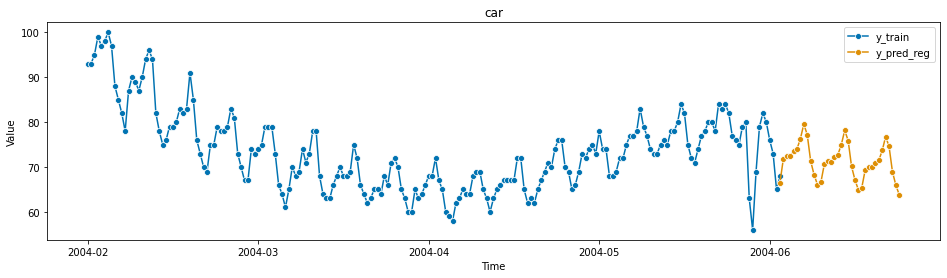

In [119]:
# Forecasted values

final_forecast = pd.DataFrame(y_pred, columns = [selected_var])

print(final_forecast)

# Save plot

fig, ax = plot_series(y_train, y_pred, labels=["y_train", "y_pred_reg"])

ax.set(title = selected_var, xlabel='Time', ylabel='Value')

fig.savefig('Graphics/' + 'forecasted_values_' + selected_var + '.png')

# Write object

final_forecast.to_excel("Output/forecasted_values.xlsx",index = True)  